Load Data

In [1]:
import json
import cv2
import numpy as np
import os
from skimage.feature import hog
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

anotations_path = 'archive'
train_anotations_file = 'train_annotations'
test_anotations_file = 'valid_annotations'

In [2]:
def get_records(path, file): 
    with open(os.path.join(path, file), 'r') as f:
        data = f.read()

    records = json.loads(data)
    return records

def get_image(path):
    files = os.listdir(path)
    image = []
    
    for file in files:
        img = cv2.imread(os.path.join(path, file))
        image.append(img)
    return image

def extract_hog_features(images):
    hog_features = []
    for image in images:
        flipped_img = cv2.flip(image, 1)
        flipped_img2 = cv2.flip(image, 0)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        #image = cv2.equalizeHist(image)
        image = cv2.resize(image, (256,256))
        hog_feature = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
        hog_features.append(hog_feature)
    return np.array(hog_features)

def build_visual_vocabulary(hog_features, num_clusters=50):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(hog_features)
    return kmeans.cluster_centers_

def build_bow_features(hog_features, visual_vocabulary):
    bow_features = []
    for hog_feature in hog_features:
        distances = []
        for cluster in visual_vocabulary:
            distance = np.linalg.norm(hog_feature-cluster)
            distances.append(distance)
        bow_feature = np.zeros(len(visual_vocabulary))
        bow_feature[np.argmin(distances)] = 1
        bow_features.append(bow_feature)
    return np.array(bow_features)


In [3]:
train_data = get_records(anotations_path, train_anotations_file)
test_data = get_records(anotations_path, test_anotations_file)

In [4]:
detection_train_labels = []
for i in range(len(train_data)):
    detection_train_labels.append(train_data[i]['bbox'])
detection_train_images = get_image('archive/train/train')

detection_test_labels = []
for i in range(len(test_data)):
    detection_test_labels.append(test_data[i]['bbox'])
detection_test_images = get_image('archive/valid/valid')

In [5]:
X_train_hog_features = extract_hog_features(detection_train_images)
X_test_hog_features = extract_hog_features(detection_test_images)
visual_vocabulary = build_visual_vocabulary(X_train_hog_features)
visual_vocabulary1 = build_visual_vocabulary(X_test_hog_features)
X_train_bow_features = build_bow_features(X_train_hog_features, visual_vocabulary)
X_test_bow_features = build_bow_features(X_test_hog_features, visual_vocabulary1)

C:\Users\d2064\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\d2064\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [6]:
xmin = []
ymin = []
xmax = []
ymax = []
print(detection_train_images[1].shape)
for i in range(len(detection_train_labels)):
    xmin.append(detection_train_labels[i][0])
    ymin.append(detection_train_labels[i][1])
    xmax.append(detection_train_labels[i][0] + detection_train_labels[i][2])
    ymax.append(detection_train_labels[i][1] + detection_train_labels[i][3])

xmin_test = []
ymin_test = []
xmax_test = []
ymax_test = []
for i in range(len(detection_test_labels)):
    xmin_test.append(detection_test_labels[i][0])
    ymin_test.append(detection_test_labels[i][1])
    xmax_test.append(detection_test_labels[i][0] + detection_test_labels[i][2])
    ymax_test.append(detection_test_labels[i][1] + detection_test_labels[i][3])

xmin = np.array(xmin)
ymin = np.array(ymin)
xmax = np.array(xmax)
ymax = np.array(ymax)

xmin_test = np.array(xmin_test)
ymin_test = np.array(ymin_test)
xmax_test = np.array(xmax_test)
ymax_test = np.array(ymax_test)


(640, 640, 3)


In [7]:
from sklearn.svm import SVR

model = SVR()
model.fit(X_train_bow_features, xmin)
xmin_y_pred = model.predict(X_test_bow_features)


model = SVR()
model.fit(X_train_bow_features, ymin)
ymin_y_pred = model.predict(X_test_bow_features)


model = SVR()
model.fit(X_train_bow_features, xmax)
xmax_y_pred = model.predict(X_test_bow_features)

model = SVR()
model.fit(X_train_bow_features, ymax)
ymax_y_pred = model.predict(X_test_bow_features)



print(detection_test_labels[0])

[227, 93, 298, 525]


In [8]:
def calculate_iou(box1, box2):
    x1_intersection = max(box1[0], box2[0])
    y1_intersection = max(box1[1], box2[1])
    x2_intersection = min(box1[2], box2[2])
    y2_intersection = min(box1[3], box2[3])
    
    intersection_area = max(0, x2_intersection - x1_intersection + 1) * max(0, y2_intersection - y1_intersection + 1)
    
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union_area = box1_area + box2_area - intersection_area
    
    iou = intersection_area / union_area
    return iou

iou:  0.41192822478784286


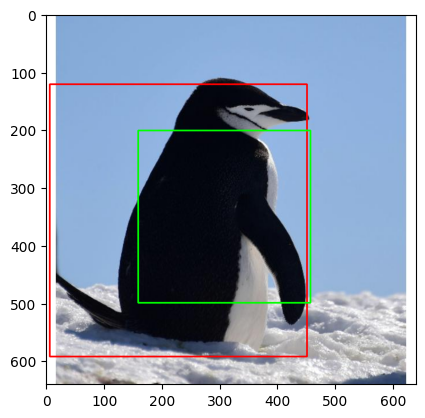

In [9]:
image = cv2.imread('archive/train/train/image_id_005.jpg')
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

img1 = cv2.rectangle(img, (int(xmin_test[5]), int(ymin_test[5])), (int(xmax_test[5]), int(ymax_test[5])), (255, 0, 0), 2)
img1 = cv2.rectangle(img1, (int(xmin_y_pred[5]), int(ymin_y_pred[5])), (int(xmax_y_pred[5]), int(ymax_y_pred[5])), (0, 255, 0), 2)

# calculate IoU
iou = calculate_iou([xmin_test[5], ymin_test[5], xmax_test[5], ymax_test[5]], [xmin_y_pred[5], ymin_y_pred[5], xmax_y_pred[5], ymax_y_pred[5]])
print("iou: ", iou)
plt.imshow(img1)
plt.show()

In [10]:
# loop through 500 images, calculate the average iou for the dataset
iou = 0
for i in range (0, 72):
    iou += calculate_iou([xmin_test[i], ymin_test[i], xmax_test[i], ymax_test[i]], [xmin_y_pred[i], ymin_y_pred[i], xmax_y_pred[i], ymax_y_pred[i]])
print(iou/72)

0.42270287051081556


Classification

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

# Create random forest classifier instance
classifier = SVC(kernel='linear', C=1.0)

y_train = []
for i in range(len(train_data)):
    y_train.append(train_data[i]['category_id'])                         

roi = []
for i in  range(len(detection_train_images)):
    img = detection_train_images[i][ymin[i]:ymax[i], xmin[i]:xmax[i]]
    roi.append(img)

# flippping the images vertically
for i in range(len(detection_train_images)):
    img = detection_train_images[i][ymin[i]:ymax[i], xmin[i]:xmax[i]]
    flipped_img = cv2.flip(img, 0)
    roi.append(flipped_img)
    y_train.append(y_train[i])


# flippping the images horizontally
for i in range(len(detection_train_images)):
    img = detection_train_images[i][ymin[i]:ymax[i], xmin[i]:xmax[i]]
    flipped_img = cv2.flip(img, 1)
    roi.append(flipped_img)
    y_train.append(y_train[i])



roi = extract_hog_features(roi)
visual_vocabulary2 = build_visual_vocabulary(roi)
roi = build_bow_features(roi, visual_vocabulary2)

roi_for_test = []
for i in  range(len(detection_test_images)):
    roi_for_test.append(detection_train_images[i][ymin_test[i]:ymax_test[i], xmin_test[i]:xmax_test[i]])

roi_for_test = extract_hog_features(roi_for_test)
visual_vocabulary3 = build_visual_vocabulary(roi_for_test)
X_test_bow_features = build_bow_features(roi_for_test, visual_vocabulary3)


# Fit the classifier to the data
classifier.fit(roi, y_train)

# predict the response
y_pred = classifier.predict(X_test_bow_features)
y_test = []
for i in range(len(test_data)):
    y_test.append(test_data[i]['category_id'])

print(y_pred[0:10])
print(y_test[0:10])

#print accuracy
print("accuracy: {}".format(accuracy_score(y_test, y_pred)))
print("f1 score: {}".format(f1_score(y_test, y_pred, average='macro')))
print("precision score: {}".format(precision_score(y_test, y_pred, average='macro')))
print("recall score: {}".format(recall_score(y_test, y_pred, average='macro')))
print("confusion matrix: \n{}".format(confusion_matrix(y_test, y_pred)))



C:\Users\d2064\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\d2064\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[2 2 2 2 2 2 2 1 2 2]
[1, 2, 2, 1, 1, 1, 2, 1, 1, 1]
accuracy: 0.4305555555555556
f1 score: 0.39693564862104186
precision score: 0.4106256206554121
recall score: 0.4305555555555555
confusion matrix: 
[[ 7 29]
 [12 24]]
